In [1]:
import sys

sys.path.append("../../src/stong_core_cython")
sys.path.append("../../src/stong_core_cython/md")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hartree_fock
import basis_data
import importlib
import matrix
from scipy.constants import physical_constants
from scipy.optimize import minimize
from scipy.linalg import eigh

importlib.reload(hartree_fock)
importlib.reload(basis_data)
importlib.reload(matrix)

from atom import *
from hartree_fock import *
from basis_data import *
from matrix import *

In [3]:
df = pd.read_csv("../make_base/sto_3g.csv")

H2のエネルギーの結合長依存性

In [4]:
def solve_H(zetas):
    atoms = [Atom("H", np.array([0.0, 0.0, 0.0]))]
    molecule = Molecule(atoms)
    basis_data = {"H": create_basis_data(df, zetas, 2, 1)}
    hartreefock = HartreeFock(molecule, basis_data, max_iter=10000, tol=1e-10)
    hartreefock.scf()
    hartreefock.calculate_total_energy()
    results = hartreefock.get_results()
    return results, hartreefock


def solve(r, zetas):
    atoms = [Atom("H", np.array([0.0, 0.0, 0.0])), Atom("H", np.array([r, 0.0, 0.0]))]
    molecule = Molecule(atoms)
    basis_data = {"H": create_basis_data(df, zetas, 2, 1)}
    hartreefock = HartreeFock(molecule, basis_data, max_iter=10000, tol=1e-10)
    hartreefock.scf()
    hartreefock.calculate_total_energy()
    results = hartreefock.get_results()
    return results, hartreefock


def get_energy(r, zetas):
    results, _ = solve(r, zetas)
    return results["energy"] + 1 / r


def solve_ci(r, zetas):
    results, hartreefock = solve(r, zetas)

    vec_up = results["vec_up"]
    vec_dn = results["vec_dn"]
    ERI = hartreefock.ERI
    T = hartreefock.T
    V = hartreefock.V
    P_ups = []
    P_dns = []
    num_orb = 10
    for i in range(num_orb):
        P_ups.append(vec_up[:, i : i + 1] @ vec_up[:, i : i + 1].T)
        P_dns.append(vec_dn[:, i : i + 1] @ vec_dn[:, i : i + 1].T)
    ci_matrix = np.zeros((num_orb, num_orb))
    for i in range(num_orb):
        ci_matrix[i, i] += np.einsum("ij, i,j", T, vec_up[:, i], vec_up[:, i])
        ci_matrix[i, i] += np.einsum("ij, i,j", V, vec_up[:, i], vec_up[:, i])
        ci_matrix[i, i] += np.einsum("ij, i,j", T, vec_dn[:, i], vec_dn[:, i])
        ci_matrix[i, i] += np.einsum("ij, i,j", V, vec_dn[:, i], vec_dn[:, i])
        for j in range(num_orb):
            ci_matrix[i, j] += np.einsum(
                "ijkl,i, j, k,l",
                ERI,
                vec_up[:, i],
                vec_up[:, j],
                vec_dn[:, i],
                vec_dn[:, j],
            )
    val, vec = eigh(ci_matrix)
    return val[0] + 1 / r

In [10]:
df_zetas = pd.read_csv("./zetas.csv")

In [6]:
res, hartree_fock = solve_H(df_zetas["H"])

Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.])])


In [7]:
rs = np.linspace(0.5, 6.0, 100)
es = []
es_ci = []
for i, r in enumerate(rs):
    print(i)
    es.append(get_energy(r, df_zetas["H"]))
    es_ci.append(solve_ci(r, df_zetas["H"]))

0
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[0.5 0.  0. ])])
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[0.5 0.  0. ])])
1
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[0.55555556 0.         0.        ])])
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[0.55555556 0.         0.        ])])
2
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[0.61111111 0.         0.        ])])
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[0.61111111 0.         0.        ])])
3
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_numb

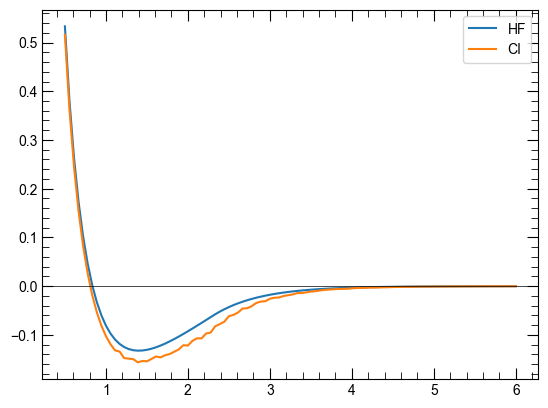

In [8]:
fig, ax = plt.subplots()
ax.plot(rs, es - 2 * res["energy"], label="HF")
ax.plot(rs, es_ci - 2 * res["energy"], label="CI")
ax.legend()
ax.axhline(0, color="black", lw=0.5)
plt.show()